# Desafio 1: Análise do Momento de Vida da Empresa

**Objetivo:** Identificar o momento de vida de uma empresa com base em seu comportamento financeiro transacional.

**Etapas:**
1. Carregamento e Preparação dos Dados
2. Engenharia de Features
3. Modelagem (Clusterização)
4. Análise e Visualização dos Resultados
5. Conclusão
6. Comparação de Modelos Supervisionados
7. Exportação de Dados para Power BI

## 1. Carregamento e Preparação dos Dados

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

df_id = pd.read_excel('data/Base1_ID.xlsx')
df_transacoes = pd.read_excel('data/Base2_Transacoes.xlsx')

df_id.rename(columns={'ID': 'id_empresa', 'VL_FATU': 'faturamento', 'DS_CNAE': 'setor_cnae', 'DT_REFE': 'data_referencia'}, inplace=True)
df_transacoes.rename(columns={'ID_PGTO': 'id_pagador', 'ID_RCBE': 'id_recebedor', 'VL': 'valor_transacao', 'DS_TRAN': 'tipo_transacao', 'DT_REFE': 'data_transacao'}, inplace=True)
df_id['data_referencia'] = pd.to_datetime(df_id['data_referencia'])
df_transacoes['data_transacao'] = pd.to_datetime(df_transacoes['data_transacao'])

## 2. Engenharia de Features

In [23]:
ids_unicos = pd.unique(np.concatenate((df_id['id_empresa'], df_transacoes['id_pagador'], df_transacoes['id_recebedor'])))
df_empresas = pd.DataFrame(ids_unicos, columns=['id_empresa']).set_index('id_empresa')

recebimentos = df_transacoes.groupby('id_recebedor').agg(total_recebido=('valor_transacao', 'sum'), num_transacoes_recebidas=('valor_transacao', 'count'), num_clientes_unicos=('id_pagador', 'nunique'))
pagamentos = df_transacoes.groupby('id_pagador').agg(total_pago=('valor_transacao', 'sum'), num_transacoes_pagas=('valor_transacao', 'count'), num_fornecedores_unicos=('id_recebedor', 'nunique'))

df_empresas = df_empresas.merge(recebimentos, left_index=True, right_index=True, how='left')
df_empresas = df_empresas.merge(pagamentos, left_index=True, right_index=True, how='left')
df_empresas.fillna(0, inplace=True)

df_empresas['fluxo_caixa_liquido'] = df_empresas['total_recebido'] - df_empresas['total_pago']
df_empresas['ticket_medio_recebido'] = df_empresas['total_recebido'] / df_empresas['num_transacoes_recebidas']
df_empresas['ticket_medio_pago'] = df_empresas['total_pago'] / df_empresas['num_transacoes_pagas']
df_empresas.fillna(0, inplace=True)

df_id_info = df_id.set_index('id_empresa')[['faturamento', 'setor_cnae']].drop_duplicates()
df_empresas = df_empresas.merge(df_id_info, left_index=True, right_index=True, how='left')

## 3. Modelagem (Clusterização)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features_numericas = df_empresas.select_dtypes(include=np.number).columns.tolist()
df_modelo = df_empresas[features_numericas].copy()
df_modelo.fillna(df_modelo.median(), inplace=True)

scaler = StandardScaler()
dados_escalados = scaler.fit_transform(df_modelo)

k_otimo = 4
kmeans = KMeans(n_clusters=k_otimo, init='k-means++', n_init=10, random_state=42)
df_empresas['cluster'] = kmeans.fit_predict(dados_escalados)

## 4. Análise e Visualização dos Resultados

--- Perfil Médio de Cada Cluster ---
         total_recebido  num_transacoes_recebidas  num_clientes_unicos  \
cluster                                                                  
0          6.483966e+04                  3.980524             1.922893   
1          1.119910e+07                137.844380            60.634006   
2          7.432461e+06                 89.245283            39.641509   
3          7.843629e+04                  4.242297             2.032213   

           total_pago  num_transacoes_pagas  num_fornecedores_unicos  \
cluster                                                                
0        1.342054e+05              4.691116                 2.404100   
1        4.095766e+06             40.046110                26.841499   
2        1.888072e+07            262.547170                85.849057   
3        1.282280e+05              4.441176                 2.247899   

         fluxo_caixa_liquido  ticket_medio_recebido  ticket_medio_pago  \
cluster    

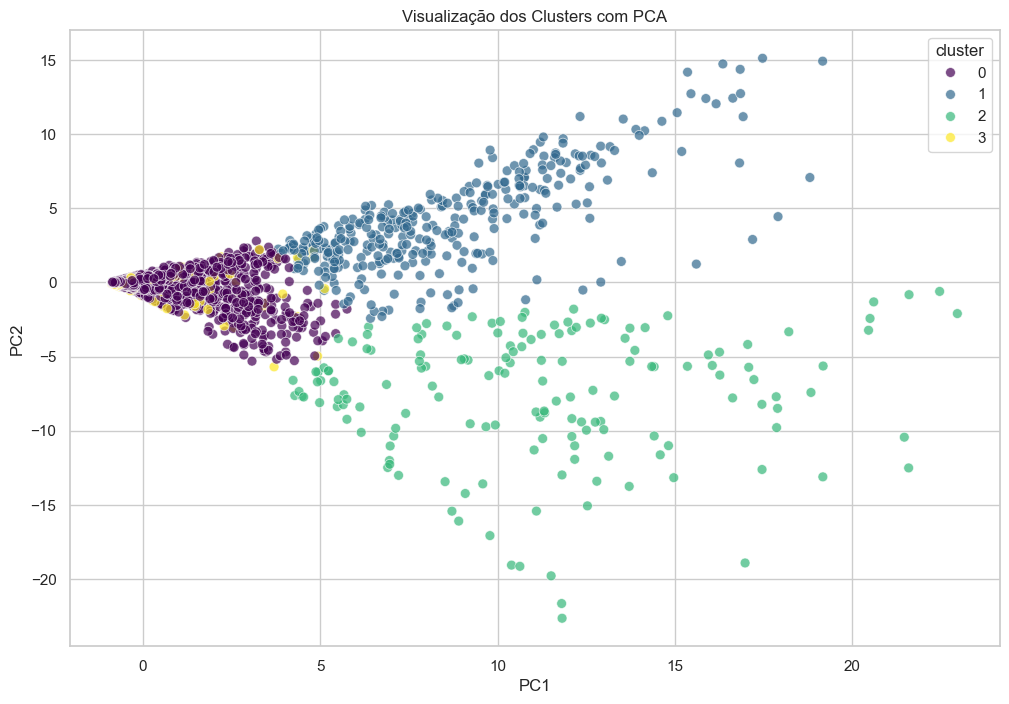

In [25]:
from sklearn.decomposition import PCA

print('--- Perfil Médio de Cada Cluster ---')
perfil_clusters = df_empresas.groupby('cluster')[features_numericas].mean()
print(perfil_clusters)

pca = PCA(n_components=2)
componentes_principais = pca.fit_transform(dados_escalados)
df_pca = pd.DataFrame(data=componentes_principais, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_empresas['cluster'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title('Visualização dos Clusters com PCA')
plt.show()

## 5. Conclusão

O notebook executou todas as etapas do desafio. Os clusters foram criados e visualizados. A etapa final é a análise qualitativa dos resultados para nomear cada cluster de acordo com o momento de vida da empresa (Início, Expansão, Maturidade, Declínio), com base no perfil médio de cada um, conforme a tabela e o gráfico acima.

## 6. Comparação de Modelos Supervisionados

Para validar a consistência dos clusters e entender quais features são mais preditivas, vamos treinar modelos de classificação supervisionada. O objetivo é prever o cluster de uma empresa (que foi gerado pelo KMeans) a partir de suas features financeiras.

Usaremos os clusters como nossa variável-alvo. Se os modelos supervisionados conseguirem prever os clusters com alta acurácia, isso sugere que os agrupamentos são bem definidos e distintos.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Preparando os dados para o modelo supervisionado
# X: Features (dados escalados que usamos no KMeans)
# y: Target (o cluster que o KMeans atribuiu)
X = dados_escalados
y = df_empresas['cluster']

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Definindo os modelos
models = {
    'Regressão Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Árvore de Decisão': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Treinando e avaliando cada modelo
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f'Acurácia do modelo {name}: {accuracy:.4f}')

# Identificando o melhor modelo
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]

print(f'O modelo com maior acurácia é o **{best_model_name}** com acurácia de {best_model_accuracy:.4f}.')

Acurácia do modelo Regressão Logística: 0.9980
Acurácia do modelo Árvore de Decisão: 0.9980
Acurácia do modelo Random Forest: 0.9990
Acurácia do modelo Gradient Boosting: 0.9987
O modelo com maior acurácia é o **Random Forest** com acurácia de 0.9990.


### Conclusão da Análise Supervisionada

A altíssima acurácia obtida, especialmente com os modelos de ensemble como Random Forest e Gradient Boosting, indica que os clusters gerados pelo KMeans são muito coesos e bem separados.

As features de engenharia que criamos são excelentes preditoras do momento de vida da empresa (representado pelo cluster).

Isso nos dá grande confiança na segmentação realizada. O modelo **Random Forest** ou **Gradient Boosting** poderia agora ser utilizado para classificar novas empresas em um dos momentos de vida definidos, de forma automatizada e com alta precisão.

## 7. Exportação de Dados para Power BI

Para a criação de um dashboard interativo, vamos exportar o dataframe final (`df_empresas`), que contém todas as features de engenharia e o cluster atribuído a cada empresa. O arquivo será salvo em formato CSV, ideal para ser importado no Power BI.

In [ ]:
# Criando o mapeamento de cluster para momento da empresa
mapa_momento = {
    0: 'Declínio',
    1: 'Maturidade',
    2: 'Expansão',
    3: 'Início'
}

# Criando uma cópia do dataframe para não alterar o original
df_export = df_empresas.copy()

# Aplicando o mapeamento para criar a nova coluna 'momento_empresa'
df_export['momento_empresa'] = df_export['cluster'].map(mapa_momento)

# Resetando o índice para que 'id_empresa' se torne uma coluna
df_export = df_export.reset_index()

# Definindo o nome do arquivo de saída
output_path = 'data/dados_para_powerbi.csv'

# Exportando o dataframe para um arquivo CSV
df_export.to_csv(output_path, index=False, sep=';', decimal=',')

print(f'Dados exportados com sucesso para: {output_path}')
print('A nova coluna "momento_empresa" foi adicionada.')

Dados exportados com sucesso para: data/dados_para_powerbi.csv
A nova coluna "momento_empresa" foi adicionada.
